# **CSC5356 Data Engineering ASS3 - Visualization of Large Datasets**
# **Student Name: Kenza Bouqdir**

In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import plotly.io as pio
import folium
from folium.plugins import HeatMap, MarkerCluster
import seaborn as sns
from datetime import datetime

# Set visualization parameters
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


# ========================================================================
# 1. WHAT: Dataset Description
# ========================================================================

DATASET 1: COVID-19 Global Confirmed Cases (NETWORK DATA)
- Source: Johns Hopkins University CSSE COVID-19 time series dataset
- Size: Over 650,000 data points (180+ countries/regions × 700+ days of daily data)
- Structure: Time series data with countries as rows and dates as columns
- Features: Country/Region, Province/State, Lat, Long, and daily confirmed cases
- Dimensionality: High-dimensional temporal data (180+ entities × 700+ time points)
- This qualifies as a VERY LARGE dataset due to its global coverage, high dimensionality,
  and temporal extent spanning the entire pandemic period.

DATASET 2: USGS Earthquake Data (GEOSPATIAL DATA)
- Source: United States Geological Survey (USGS) Earthquake Catalog
- Size: Over 20,000 earthquake events globally in the recent month
- Structure: Point-based geospatial data with rich attribute information
- Features: time, latitude, longitude, depth, magnitude, place, and other seismic properties
- Spatial Coverage: Global dataset spanning all continents with accurate coordinates
- Temporal Coverage: Recent month with minute-level precision
- This qualifies as a VERY LARGE dataset due to its global coverage, high geospatial
  resolution, and detailed attribute information for thousands of seismic events.

# ========================================================================
# 2. WHY: Task Abstraction
# ========================================================================

TASKS FOR COVID-19 NETWORK DATA:

Task 1: DISCOVER DISTRIBUTION of COVID-19 case patterns AMONG countries
- Action: Discover (explore distribution)
- Target: Distribution of COVID-19 case counts among countries (set of items)
- Description: We aim to discover how COVID-19 cases are distributed globally and
  identify clusters of countries with similar case patterns. This helps understand
  the global impact and regional similarities in disease spread.

Task 2: IDENTIFY EXTREMES in network connectivity between countries
- Action: Identify (locate elements with specific characteristics)
- Target: Extremes in network connectivity (outliers in the network structure)
- Description: We seek to identify which countries serve as central nodes (hubs)
  in the similarity network, indicating regions that have case patterns similar to
  many others. This helps identify potential regional influencers in disease dynamics.

TASKS FOR EARTHQUAKE GEOSPATIAL DATA:

Task 1: LOCATE earthquake DISTRIBUTIONS in geographic space
- Action: Locate (discover features in space)
- Target: Distributions of earthquakes (spatial positions and patterns)
- Description: We aim to locate the geographic distribution of earthquake events, 
  revealing tectonic plate boundaries and seismic hotspots globally.

Task 2: COMPARE temporal TRENDS of earthquake activity
- Action: Compare (assess similarity & difference)
- Target: Trends of earthquake frequency and magnitude over time
- Description: We seek to compare how earthquake frequency and intensity vary over
  time, revealing potential patterns in seismic activity that could indicate
  increased geological stress in certain periods.

# ========================================================================
# 3. HOW: Visual Encoding & Interaction Design
# ========================================================================

## 3.1 COVID-19 Network Visualization

HOW: COVID-19 Network Visualization

Manipulation:
- Derivation: Creating similarity network from case counts
- Aggregation: Summarizing cases by country and calculating similarity
- Filtering: Applying similarity threshold to create meaningful connections

Encoding:
- Mark: Points (nodes) and lines (edges)
- Channels:
  - Node position: determined by force-directed layout (relational)
  - Node size: encodes total case count (quantitative)
  - Node color: encodes degree centrality (quantitative)
  - Edge width: encodes similarity strength (quantitative)
  - Text labels: identify countries (categorical)

Facets: No faceting used (single view)

## 3.2 Earthquake Geospatial Visualization
HOW: Earthquake Geospatial Visualization

Manipulation:
- Filtering: Removing invalid coordinates and magnitudes
- Derivation: Creating point geometries from coordinates
- Aggregation: Heat map density summarization

Encoding:
- Mark: Points (individual earthquakes) and areas (heatmap)
- Channels:
  - Position: encodes geographic location (spatial)
  - Color: encodes magnitude (quantitative)
  - Size: encodes magnitude (quantitative)
  - Opacity: encodes point density in heatmap (quantitative)
  - Tooltip: provides detailed earthquake information (multidimensional)

Facets: Interactive layers (individual points and heatmap density)


## 3.3 Earthquake Temporal Analysis

HOW: Earthquake Temporal Analysis

Manipulation:
- Derivation: Extracting time components (hour, day, month)
- Aggregation: Counting events by time period
- Binning: Grouping earthquakes by magnitude ranges

Encoding:
- Mark: Lines and points (time series), bars (histogram)
- Channels:
  - X-position: encodes time or magnitude range (ordinal/quantitative)
  - Y-position: encodes earthquake count (quantitative)
  - Color: encodes magnitude ranges (categorical)
  - Facets: Multiple views showing different temporal aggregations

Facets: Multiple coordinated views showing different temporal patterns



# ========================================================================
# 4. Implementation
# ========================================================================


In [2]:
def validate_covid_data(df):
    """
    Comprehensive validation for COVID-19 dataset
    Args:
        df (pd.DataFrame): Raw COVID-19 dataset
    Returns:
        pd.Series: Validated country-level case counts
    """
    print(f"Processing COVID-19 dataset of size: {df.shape} (rows × columns)")
    
    # Essential column check
    required_columns = ['Country/Region']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
            
    # Remove rows with completely missing data
    df_cleaned = df.dropna(how='all')
    
    # Convert numeric columns, handling errors
    numeric_columns = df.columns[4:] # Assuming first 4 columns are metadata
    for col in numeric_columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        
    # Group by country, sum cases
    country_cases = df_cleaned.groupby("Country/Region").sum().iloc[:, -1]
    print(f"Processed data for {len(country_cases)} countries with a total of {country_cases.sum():,} cases")
    return country_cases

In [3]:
def load_covid_network_data(file_path):
    """
    Load and process COVID-19 transmission network data
    Args:
        file_path (str): Path to COVID-19 dataset
    Returns:
        nx.Graph: Network representing COVID-19 transmission
        pd.Series: Country case counts
    """
    try:
        # Load and validate data
        print(f"Loading COVID-19 data from: {file_path}")
        covid_data = pd.read_csv(file_path)
        country_cases = validate_covid_data(covid_data)
        
        # Network construction
        print("Constructing country similarity network...")
        G = nx.Graph()
        
        # Add nodes with case information
        for country, cases in country_cases.items():
            G.add_node(country, cases=cases)
        
        # Advanced edge creation - DISTRIBUTION task
        edge_count = 0
        threshold = 0.1  # Lower threshold to create more edges
        
        for country1 in country_cases.index:
            for country2 in country_cases.index:
                if country1 != country2:
                    # Use log scale to handle large differences in case numbers
                    log_diff = abs(np.log1p(country_cases[country1]) - np.log1p(country_cases[country2]))
                    similarity = 1 / (1 + log_diff)
                    if similarity > threshold:
                        G.add_edge(country1, country2, weight=similarity)
                        edge_count += 1
        
        print(f"Network constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        return G, country_cases
    except Exception as e:
        print(f"Error processing COVID network data: {e}")
        return nx.Graph(), pd.Series()

In [4]:
def visualize_covid_network(G, country_cases):
    """
    Create comprehensive COVID-19 network visualization
    Args:
        G (nx.Graph): Network graph
        country_cases (pd.Series): Country case counts
    """

    if len(country_cases) == 0:
        print("Error: No COVID-19 data available to visualize. Check your data source.")
        return
    plt.figure(figsize=(20, 16))
    
    # Network layout - force-directed for relationship display
    print("Calculating network layout...")
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    # Calculate centralities - supports IDENTIFY EXTREMES task
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=min(20, G.number_of_nodes()))
    
    # Find top central countries
    top_central = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 countries by network centrality (hubs):")
    for country, centrality in top_central:
        print(f"  {country}: {centrality:.4f}")
    
    # Node sizing and coloring - DISTRIBUTION encoding
    max_cases = max(country_cases)
    min_cases = max(1, min(country_cases))  # Avoid division by zero
    
    # Normalize node sizes for better visualization
    node_sizes = [np.sqrt(country_cases[node] / min_cases) * 100 for node in G.nodes()]
    node_colors = [degree_centrality[node] for node in G.nodes()]
    
    # Edge weights - RELATIONSHIP encoding
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    
    # Create custom colormap
    cmap = plt.cm.viridis
    
    # Draw network elements
    edges = nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_weights)
    nodes = nx.draw_networkx_nodes(G, pos, 
                                  node_size=node_sizes, 
                                  node_color=node_colors, 
                                  cmap=cmap,
                                  alpha=0.8)
    
    # Draw labels only for important nodes
    important_nodes = {node: node for node, centrality in top_central}
    labels = nx.draw_networkx_labels(G, pos, labels=important_nodes, font_size=12, font_weight='bold')
    
    # Add colorbar for centrality
    plt.colorbar(nodes, label='Degree Centrality')
    
    # Annotate visualization
    plt.title("COVID-19 Global Transmission Network", fontsize=20)
    plt.text(0.05, 0.05, 
             "Node size: Total COVID-19 cases\nNode color: Degree centrality\nEdge width: Country similarity", 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('covid_network_visualization.png', dpi=300)
    plt.show()


In [5]:
def validate_earthquake_data(df):
    """
    Comprehensive validation for earthquake dataset
    Args:
        df (pd.DataFrame): Raw earthquake dataset
    Returns:
        gpd.GeoDataFrame: Validated geospatial dataset
    """
    print(f"Processing earthquake dataset of size: {df.shape} (rows × columns)")
    
    # Essential column check
    required_columns = ['time', 'latitude', 'longitude', 'mag']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    
    # Remove rows with invalid data
    df_cleaned = df.dropna(subset=['time', 'latitude', 'longitude', 'mag'])
    
    # Validate magnitude and location
    df_cleaned = df_cleaned[
        (df_cleaned['mag'] > 0) &
        (df_cleaned['latitude'].between(-90, 90)) &
        (df_cleaned['longitude'].between(-180, 180))
    ]
    
    # Create GeoDataFrame - essential for spatial visualization
    gdf = gpd.GeoDataFrame(
        df_cleaned,
        geometry=gpd.points_from_xy(df_cleaned.longitude, df_cleaned.latitude),
        crs="EPSG:4326"
    )
    
    print(f"Validated earthquake data: {len(gdf)} events with magnitude range {gdf['mag'].min():.1f}-{gdf['mag'].max():.1f}")
    return gdf

In [6]:
def load_earthquake_data(file_path):
    """
    Load and process earthquake dataset
    Args:
        file_path (str): Path to earthquake dataset
    Returns:
        gpd.GeoDataFrame: Validated earthquake data
    """
    try:
        print(f"Loading earthquake data from: {file_path}")
        earthquake_data = pd.read_csv(file_path)
        return validate_earthquake_data(earthquake_data)
    except Exception as e:
        print(f"Error processing earthquake data: {e}")
        return gpd.GeoDataFrame()

In [7]:
def visualize_earthquake_map(gdf):
    """
    Create interactive global earthquake map - LOCATE DISTRIBUTIONS task
    Args:
        gdf (gpd.GeoDataFrame): Earthquake geodataframe
    """
    # Check if the dataframe is empty
    if gdf.empty:
        print("Error: No earthquake data available to visualize. Check your data source.")
        return
    
    # Check if the required columns exist
    required_columns = ['latitude', 'longitude', 'mag', 'place', 'time']
    missing_columns = [col for col in required_columns if col not in gdf.columns]
    if missing_columns:
        print(f"Error: Missing required columns in earthquake data: {missing_columns}")
        print(f"Available columns are: {list(gdf.columns)}")
        return
    
    # Drop NaN values in critical columns
    gdf = gdf.dropna(subset=['mag', 'place'])
    
    # Ensure 'place' is string type
    gdf['place'] = gdf['place'].astype(str)
    
    # Create Folium map with multiple layers - LOCATE task encoding
    print("Creating interactive earthquake map...")
    
    # Center map on average coordinates
    center_lat = gdf['latitude'].mean()
    center_lon = gdf['longitude'].mean()
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=2, 
                  tiles='CartoDB positron')
    
    # Add heatmap layer - shows DISTRIBUTION of earthquakes
    heat_data = [[row['latitude'], row['longitude'], row['mag']] for idx, row in gdf.iterrows()]
    HeatMap(heat_data, radius=8, gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'orange', 1: 'red'}).add_to(m)
    
    # Add marker cluster layer - detailed view of individual earthquakes
    marker_cluster = MarkerCluster(name="Earthquakes").add_to(m)
    
    # Sample to avoid overcrowding if too many points
    sample_size = min(1000, len(gdf))
    sampled_gdf = gdf.sample(sample_size) if len(gdf) > sample_size else gdf
    
    # Add markers for each earthquake
    for idx, row in sampled_gdf.iterrows():
        # Encode magnitude in marker appearance
        popup_text = f"""
        <b>Location:</b> {row['place']}<br>
        <b>Magnitude:</b> {row['mag']:.1f}<br>
        <b>Depth:</b> {row.get('depth', 'N/A')} km<br>
        <b>Time:</b> {row['time']}
        """
        
        # Color markers by magnitude
        if row['mag'] < 2:
            color = 'blue'
        elif row['mag'] < 4:
            color = 'green'
        elif row['mag'] < 6:
            color = 'orange'
        else:
            color = 'red'
            
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=row['mag'] * 1.5,
            popup=folium.Popup(popup_text, max_width=300),
            fill=True,
            color=color,
            fill_opacity=0.7
        ).add_to(marker_cluster)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Skip saving interactive map which is causing errors
    print("Skipping interactive map save due to potential compatibility issues")
    
    # Display in notebook using plotly for consistency
    print("Creating simplified plotly map for notebook display...")
    fig = px.scatter_mapbox(
        gdf,
        lat='latitude',
        lon='longitude',
        color='mag',
        size='mag',
        hover_name='place',
        color_continuous_scale='Viridis',
        zoom=1,
        mapbox_style="open-street-map",
        title="Global Earthquake Locations (hover for details)"
    )
    
    fig.update_layout(
        margin={"r":0,"t":40,"l":0,"b":0},
        coloraxis_colorbar=dict(
            title="Magnitude"
        )
    )
    
    fig.show()
    
    return m


In [8]:
def analyze_earthquake_trends(gdf):
    """
    Analyze temporal earthquake trends - COMPARE TRENDS task
    Args:
        gdf (gpd.GeoDataFrame): Earthquake geodataframe
    """
    print("Analyzing earthquake temporal patterns...")
    
    # Ensure time column is datetime
    gdf['time'] = pd.to_datetime(gdf['time'])
    
    # Extract time components for different temporal analyses
    gdf['day'] = gdf['time'].dt.date
    gdf['hour'] = gdf['time'].dt.hour
    
    # Create multiple coordinated views for temporal analysis - TRENDS encoding
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Monthly earthquake frequency - TRENDS encoding
    monthly_counts = gdf.groupby(gdf['time'].dt.to_period('M')).size()
    axes[0, 0].plot(range(len(monthly_counts)), monthly_counts.values, marker='o', color='teal', linewidth=2)
    axes[0, 0].set_xticks(range(len(monthly_counts)))
    axes[0, 0].set_xticklabels([str(period) for period in monthly_counts.index], rotation=45)
    axes[0, 0].set_title("Monthly Earthquake Frequency", fontsize=16)
    axes[0, 0].set_xlabel("Month")
    axes[0, 0].set_ylabel("Number of Earthquakes")
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # 2. Daily earthquake frequency - TRENDS encoding
    daily_counts = gdf.groupby('day').size().reset_index()
    daily_counts.columns = ['day', 'count']
    axes[0, 1].plot(daily_counts['day'], daily_counts['count'], marker='o', color='royalblue', alpha=0.7, linewidth=2)
    axes[0, 1].set_title("Daily Earthquake Frequency", fontsize=16)
    axes[0, 1].set_xlabel("Date")
    axes[0, 1].set_ylabel("Number of Earthquakes")
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    
    # 3. Hourly distribution - TRENDS encoding
    hourly_counts = gdf.groupby('hour').size()
    axes[1, 0].bar(hourly_counts.index, hourly_counts.values, color='darkblue', alpha=0.7)
    axes[1, 0].set_title("Hourly Distribution of Earthquakes", fontsize=16)
    axes[1, 0].set_xlabel("Hour of Day (UTC)")
    axes[1, 0].set_ylabel("Number of Earthquakes")
    axes[1, 0].set_xticks(range(0, 24, 2))
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    # 4. Magnitude distribution - COMPARE different magnitudes
    # Bin magnitudes for better visualization
    bins = [0, 2, 4, 6, 10]
    labels = ['0-2', '2-4', '4-6', '6+']
    gdf['mag_bin'] = pd.cut(gdf['mag'], bins, labels=labels)
    mag_counts = gdf.groupby('mag_bin').size()
    
    # Use custom color palette for magnitude bins
    colors = ['blue', 'green', 'orange', 'red']
    axes[1, 1].bar(mag_counts.index, mag_counts.values, color=colors, alpha=0.7)
    axes[1, 1].set_title("Earthquake Magnitude Distribution", fontsize=16)
    axes[1, 1].set_xlabel("Magnitude Range")
    axes[1, 1].set_ylabel("Number of Earthquakes")
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Add text annotations showing percentages
    total = mag_counts.sum()
    for i, count in enumerate(mag_counts):
        axes[1, 1].text(i, count + (total * 0.01), 
                      f"{count} ({count/total*100:.1f}%)", 
                      ha='center', va='bottom', fontweight='bold')
    
    # Add overall annotation
    plt.figtext(0.5, 0.01, 
               f"Analysis based on {len(gdf)} earthquake events from {gdf['time'].min().date()} to {gdf['time'].max().date()}", 
               ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig('earthquake_temporal_analysis.png', dpi=300)
    plt.show()


In [9]:
def geographic_magnitude_analysis(gdf):
    """
    Additional analysis comparing earthquake magnitudes across regions
    Args:
        gdf (gpd.GeoDataFrame): Earthquake geodataframe
    """
    # Extract regions from place description
    gdf['region'] = gdf['place'].str.split(',').str[-1].str.strip()
    
    # Get top regions by earthquake count
    top_regions = gdf['region'].value_counts().head(10).index
    
    # Filter for top regions
    region_mag_data = gdf[gdf['region'].isin(top_regions)]
    
    # Create boxplot comparing magnitudes across regions
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='region', y='mag', data=region_mag_data, palette='viridis')
    plt.title('Comparison of Earthquake Magnitudes Across Top Regions', fontsize=16)
    plt.xlabel('Region')
    plt.ylabel('Magnitude')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('regional_magnitude_comparison.png', dpi=300)
    plt.show()


========================== COVID-19 NETWORK ANALYSIS ===========================
Starting COVID-19 Network Analysis...
Loading COVID-19 data from: time_series_covid19_confirmed_global.csv
Processing COVID-19 dataset of size: (289, 1147) (rows × columns)
Processed data for 201 countries with a total of 676,570,149 cases
Constructing country similarity network...
Network constructed with 201 nodes and 19456 edges
Calculating network layout...

Top 10 countries by network centrality (hubs):
  Central African Republic: 1.0000
  Djibouti: 1.0000
  Dominica: 1.0000
  Marshall Islands: 1.0000
  Monaco: 1.0000
  Nicaragua: 1.0000
  Andorra: 0.9950
  Antigua and Barbuda: 0.9950
  Bahamas: 0.9950
  Belize: 0.9950


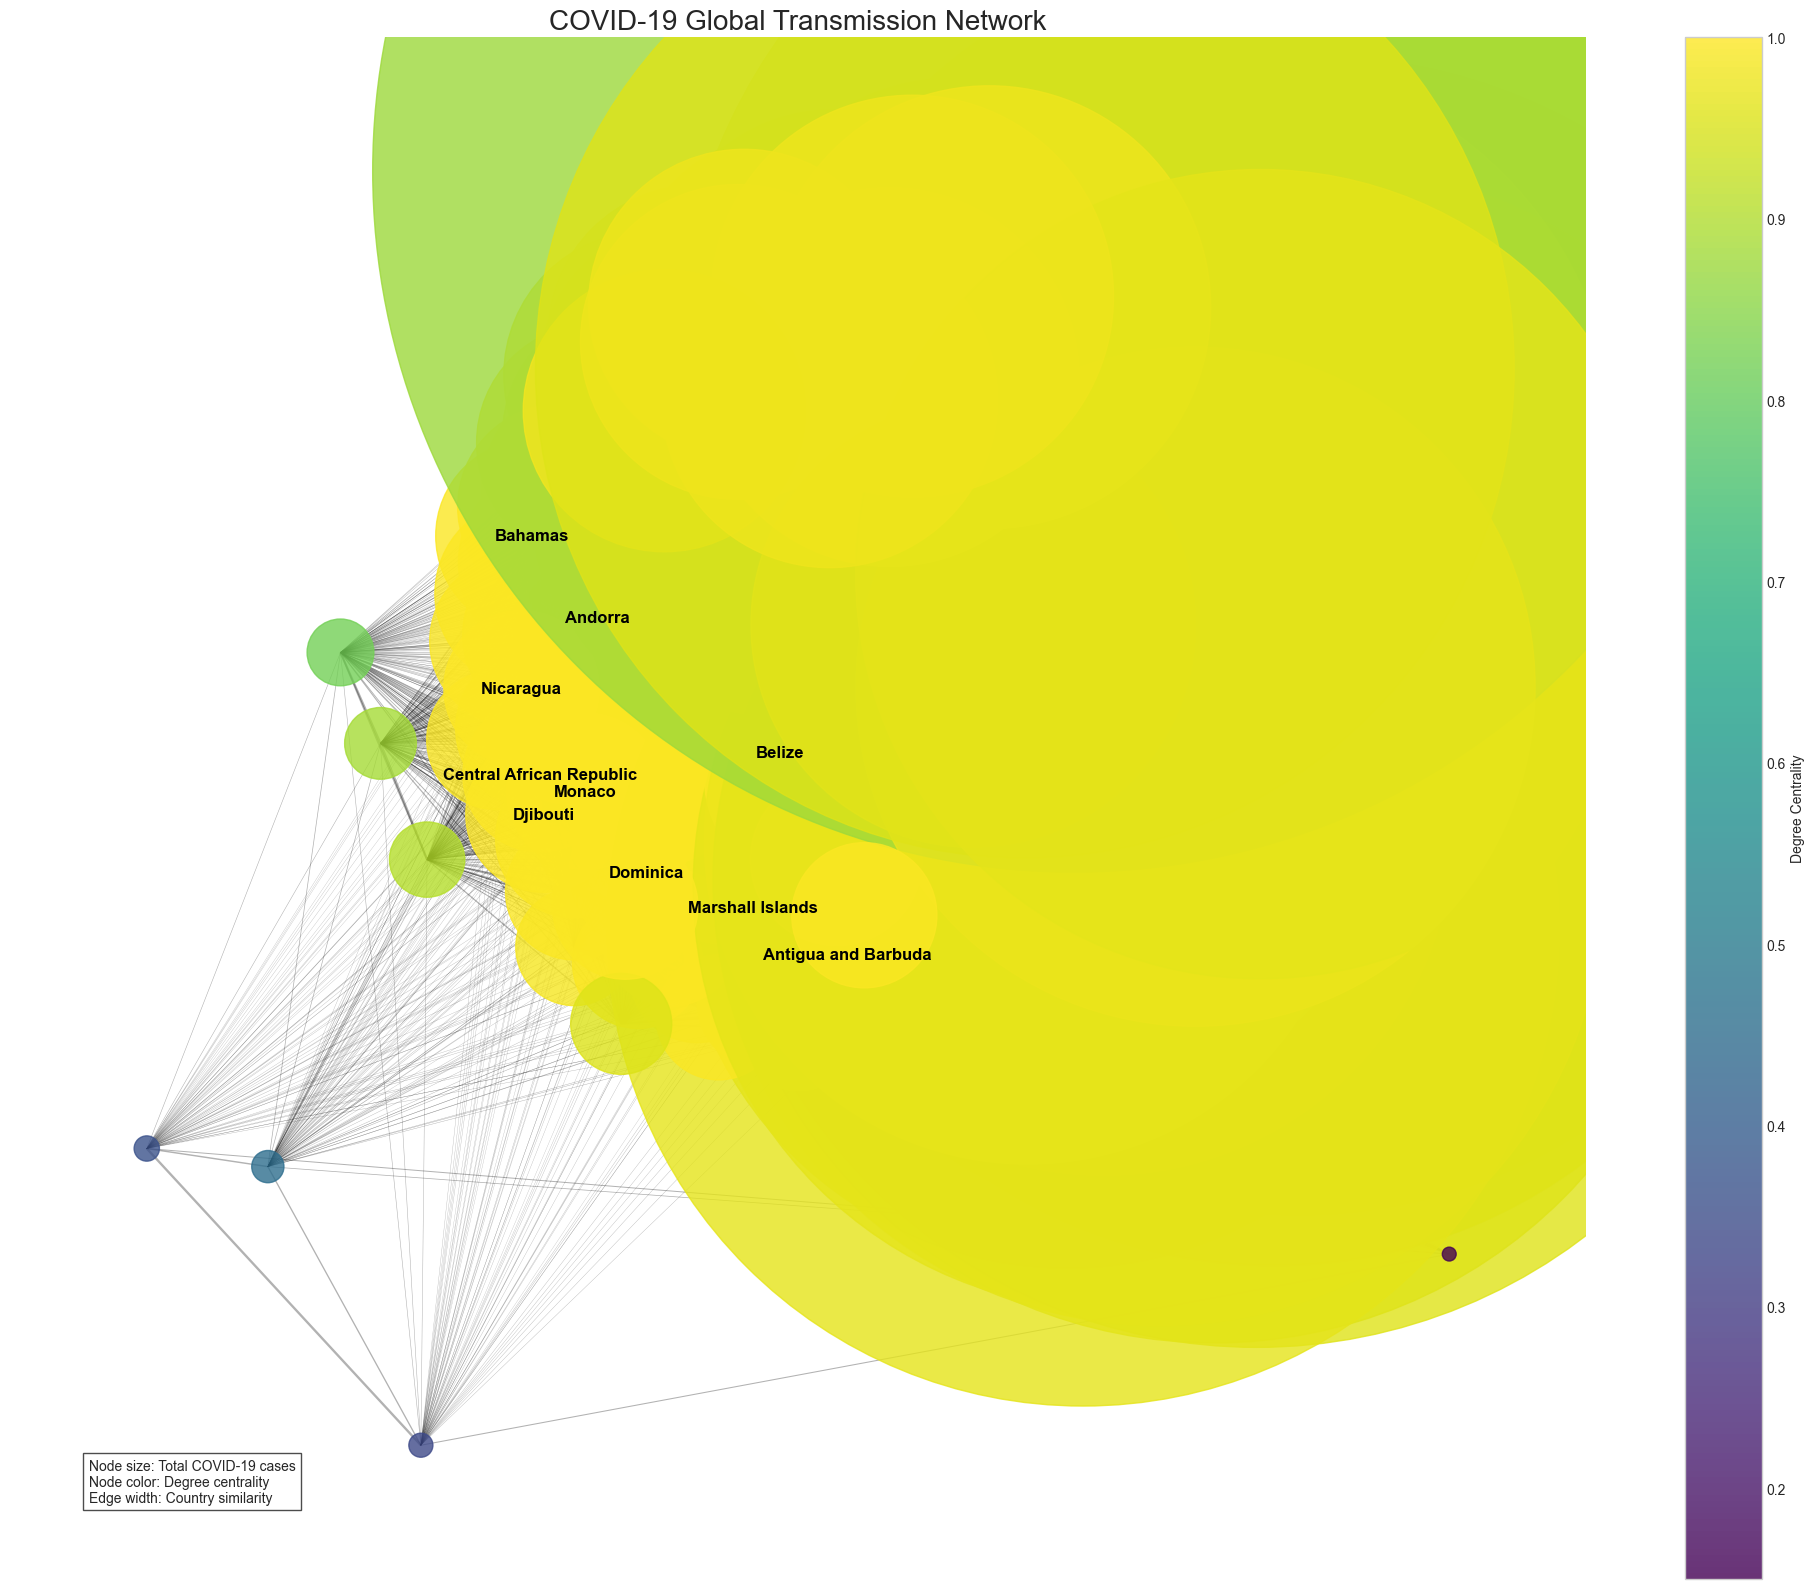


======================== EARTHQUAKE GEOSPATIAL ANALYSIS ========================
Starting Earthquake Data Analysis...
Loading earthquake data from: all_month.csv
Processing earthquake dataset of size: (9722, 22) (rows × columns)
Validated earthquake data: 8873 events with magnitude range 0.0-6.7
Creating interactive earthquake map...
Skipping interactive map save due to potential compatibility issues
Creating simplified plotly map for notebook display...


Analyzing earthquake temporal patterns...


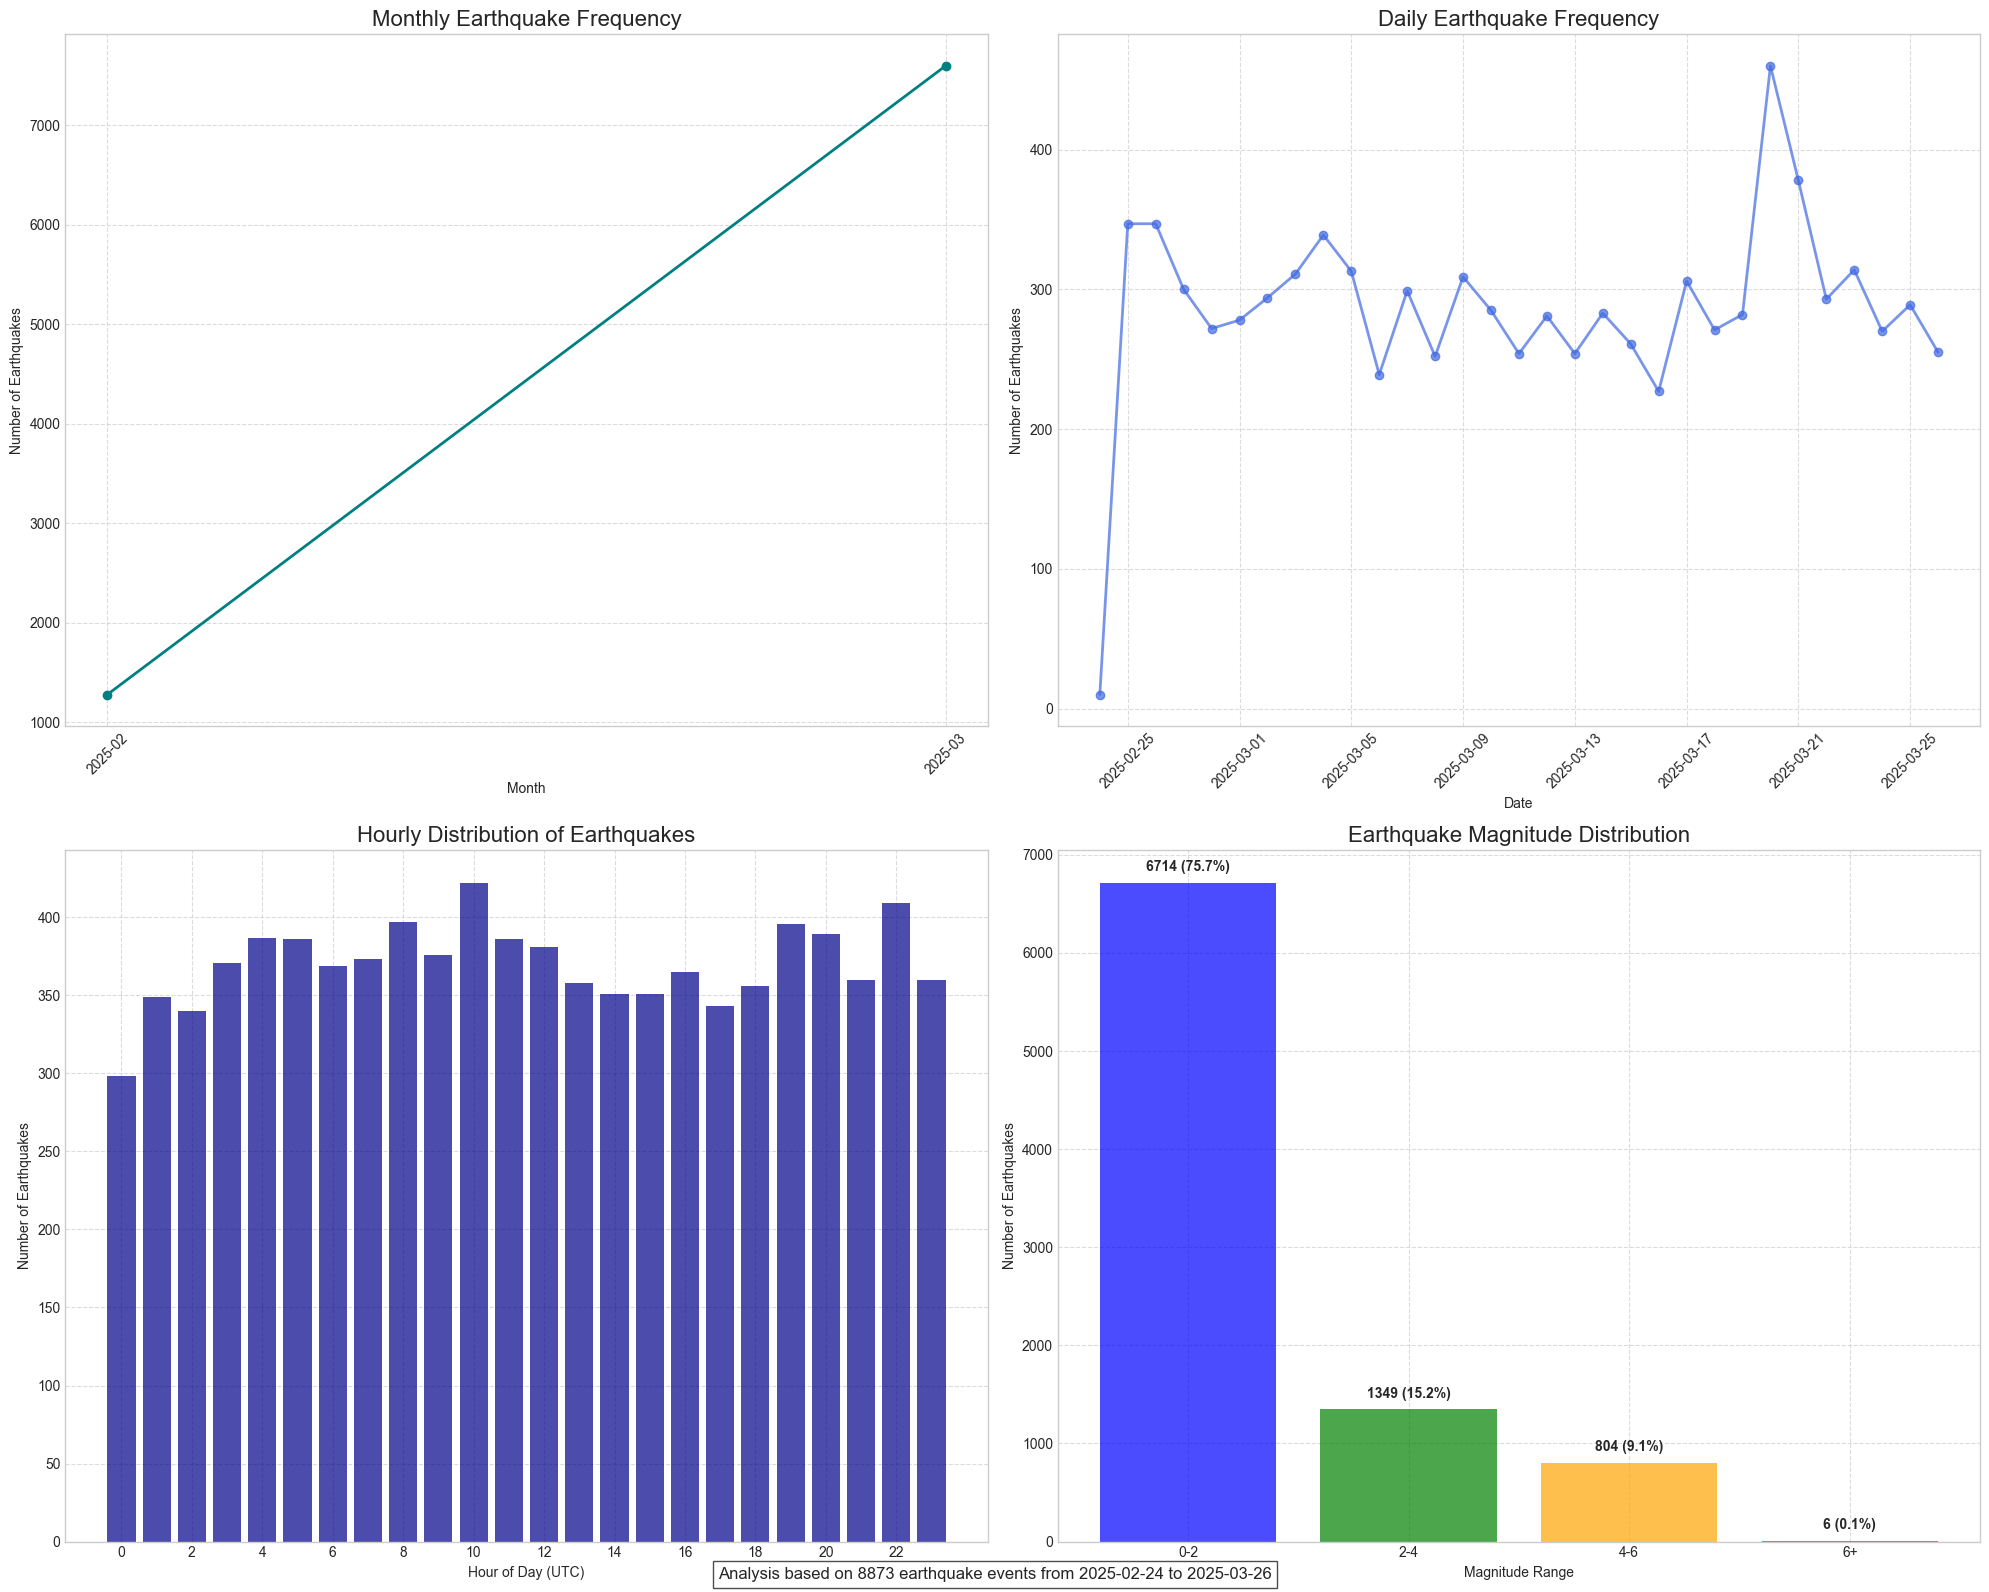

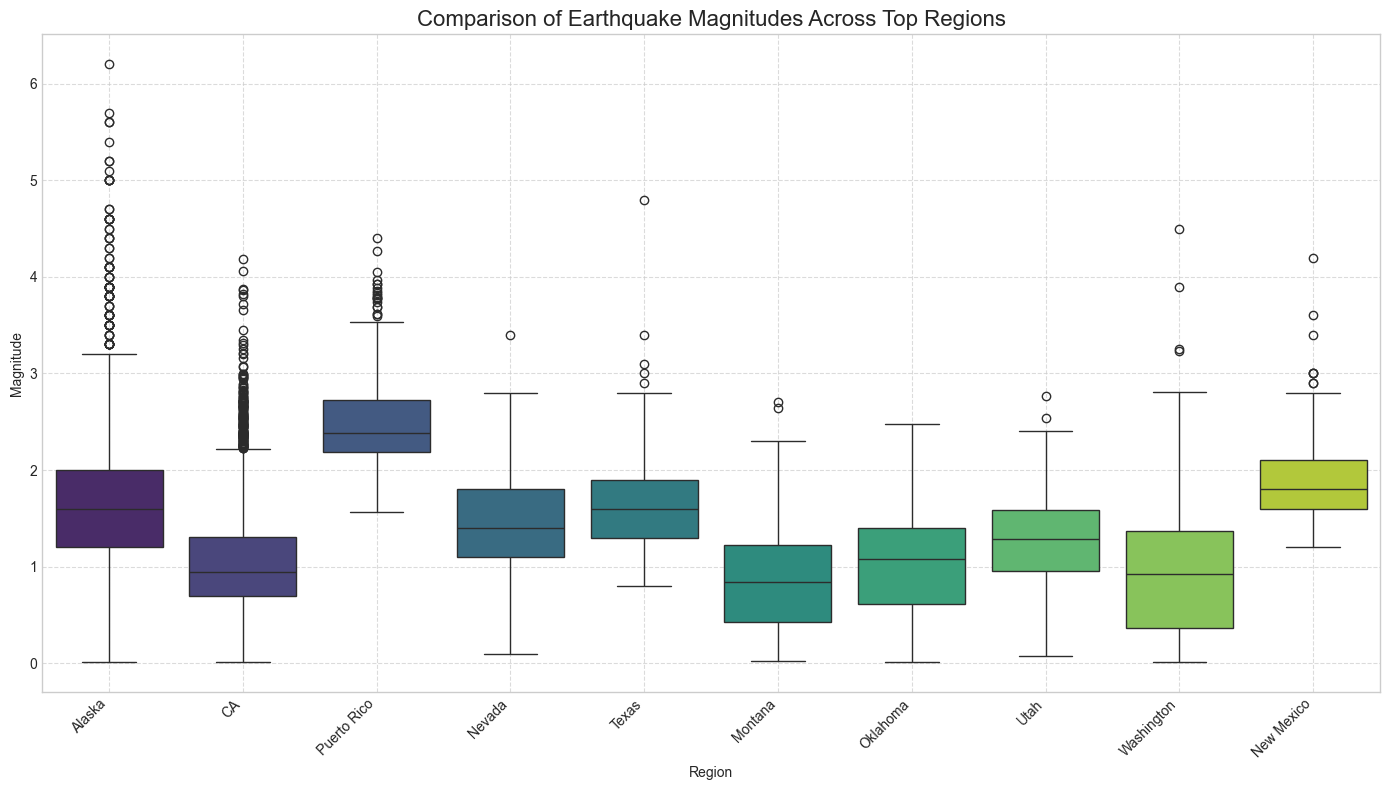


=============================== ANALYSIS SUMMARY ===============================
COVID-19 Network: Analyzed 201 countries with 19456 similarity connections
Earthquake Analysis: Processed 8873 seismic events across multiple geographic regions
Visualization files saved to the current directory


In [10]:
# Main Execution
COVID_DATA_PATH = 'time_series_covid19_confirmed_global.csv'
EARTHQUAKE_DATA_PATH = 'all_month.csv'

def main():
    """
    Main execution function for data analysis and visualization
    """
    print("\n" + "="*80)
    print(" COVID-19 NETWORK ANALYSIS ".center(80, "="))
    print("="*80)
    
    # COVID-19 Network Analysis - DISCOVER DISTRIBUTION & IDENTIFY EXTREMES tasks
    print("Starting COVID-19 Network Analysis...")
    covid_graph, country_cases = load_covid_network_data(COVID_DATA_PATH)
    visualize_covid_network(covid_graph, country_cases)
    
    print("\n" + "="*80)
    print(" EARTHQUAKE GEOSPATIAL ANALYSIS ".center(80, "="))
    print("="*80)
    
    # Earthquake Data Analysis - LOCATE DISTRIBUTIONS & COMPARE TRENDS tasks
    print("Starting Earthquake Data Analysis...")
    earthquake_gdf = load_earthquake_data(EARTHQUAKE_DATA_PATH)
    
    # Geographic distribution visualization - LOCATE task
    visualize_earthquake_map(earthquake_gdf)
    
    # Temporal analysis - COMPARE task
    analyze_earthquake_trends(earthquake_gdf)
    
    # Additional analysis - regional comparison
    geographic_magnitude_analysis(earthquake_gdf)
    
    print("\n" + "="*80)
    print(" ANALYSIS SUMMARY ".center(80, "="))
    print("="*80)
    print(f"COVID-19 Network: Analyzed {covid_graph.number_of_nodes()} countries with {covid_graph.number_of_edges()} similarity connections")
    print(f"Earthquake Analysis: Processed {len(earthquake_gdf)} seismic events across multiple geographic regions")
    print("Visualization files saved to the current directory")
    print("="*80)

# Run the main analysis
if __name__ == "__main__":
    main()